## Ion Etching Machine Condition-Based Maintenance and Remaining Useful Life Analysis

#Data Loading

In [1]:
#prod
#!pip install imbalanced-learn
# !pip install lightgbm
# !pip install rfpimp

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from statistics import mean
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# import rfpimp
import lightgbm as lgb

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
#prod
#Data stored in Google Drive, must authenticate to pull data
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
#prod
#01_M02_DC_train
#https://drive.google.com/file/d/1DO8bKxsTZe8gQ_zNnf6X1-9xlsWw37y2/view?usp=sharing
fileDownloaded = drive.CreateFile({'id':'1DO8bKxsTZe8gQ_zNnf6X1-9xlsWw37y2'})
fileDownloaded.GetContentFile('01_M02_DC_train.csv')

#01_M02_train_fault_data
#https://drive.google.com/file/d/1dppx60e2tdu4nm2XvZ1lRlMVPnVI4cvV/view?usp=sharing
fileDownloaded = drive.CreateFile({'id':'1dppx60e2tdu4nm2XvZ1lRlMVPnVI4cvV'})
fileDownloaded.GetContentFile('01_M02_train_fault_data.csv')

#01_M02_DC_train_ttf
#https://drive.google.com/file/d/1xBhlyjDhO1t_jXJLsKxP-SXD0XhKtmAU/view?usp=sharing
fileDownloaded = drive.CreateFile({'id':'1xBhlyjDhO1t_jXJLsKxP-SXD0XhKtmAU'})
fileDownloaded.GetContentFile('01_M02_DC_train_ttf.csv')

#loading into CSVs
df_train = pd.read_csv('01_M02_DC_train.csv', delimiter=',')
df_train.set_index('time')

df_fault = pd.read_csv('01_M02_train_fault_data.csv', delimiter=',')
df_fault.set_index('time')

df_ttf = pd.read_csv('01_M02_DC_train_ttf.csv', delimiter=',')
df_ttf.set_index('time')


# #03_M02_DC_train
# #https://drive.google.com/file/d/1Mho3WwCHX5JUo5IZwibV5MNBvJr_ZRhJ/view?usp=share_link
# fileDownloaded = drive.CreateFile({'id':'1Mho3WwCHX5JUo5IZwibV5MNBvJr_ZRhJ'})
# fileDownloaded.GetContentFile('03_M02_DC_train.csv')

# #03_M02_train_fault_data
# #https://drive.google.com/file/d/1-uZaGxkZBF-wrg5mBIL1WIL187Bc_cUt/view?usp=sharing
# fileDownloaded = drive.CreateFile({'id':'1-uZaGxkZBF-wrg5mBIL1WIL187Bc_cUt'})
# fileDownloaded.GetContentFile('03_M02_train_fault_data.csv')

# #03_M02_DC_train_ttf
# #https://drive.google.com/file/d/1IpBcjBap0LCVqKLb2Uwk3biTuXlpB4qF/view?usp=sharing
# fileDownloaded = drive.CreateFile({'id':'1IpBcjBap0LCVqKLb2Uwk3biTuXlpB4qF'})
# fileDownloaded.GetContentFile('03_M02_DC_train_ttf.csv')

# #loading into CSVs
# df_train = pd.read_csv('03_M02_DC_train.csv', delimiter=',')
# df_train.set_index('time')

# df_fault = pd.read_csv('03_M02_train_fault_data.csv', delimiter=',')
# df_fault.set_index('time')

# df_ttf = pd.read_csv('03_M02_DC_train_ttf.csv', delimiter=',')
# df_ttf.set_index('time')

,TTF_FlowCool Pressure Dropped Below Limit,TTF_Flowcool Pressure Too High Check Flowcool Pump,TTF_Flowcool leak
time,,,
3283834,623234.0,9146470.0,632514.0
3283838,623230.0,9146466.0,632510.0
3283842,623226.0,9146462.0,632506.0
3283846,623222.0,9146458.0,632502.0
3283850,623218.0,9146454.0,632498.0
...,...,...,...
39789824,NaN,NaN,NaN
39789828,NaN,NaN,NaN
39789832,NaN,NaN,NaN


# Preprocessing

In [4]:
#prod
#Make sure the TTFs are all divisible by 4, and subtract mod 4 if not
df_ttf['TTF_FlowCool Pressure Dropped Below Limit'] = df_ttf['TTF_FlowCool Pressure Dropped Below Limit'].sub(df_ttf['TTF_FlowCool Pressure Dropped Below Limit'] % 4)
df_ttf['TTF_Flowcool Pressure Too High Check Flowcool Pump'] = df_ttf['TTF_Flowcool Pressure Too High Check Flowcool Pump'].sub(df_ttf['TTF_Flowcool Pressure Too High Check Flowcool Pump'] % 4)
df_ttf['TTF_Flowcool leak'] = df_ttf['TTF_Flowcool leak'].sub(df_ttf['TTF_Flowcool leak'] % 4)

#set failure time to mod 4 as well so the time index matches other datasets
df_fault['time'] = df_fault['time'].sub(df_fault['time'] % 4)

# #sanity check
# print(df_ttf.loc[df_ttf['TTF_FlowCool Pressure Dropped Below Limit'].isin([1, 2, 3])])
# print(df_ttf.loc[df_ttf['TTF_Flowcool Pressure Too High Check Flowcool Pump'].isin([1, 2, 3])])
# print(df_ttf.loc[df_ttf['TTF_Flowcool leak'].isin([1, 2, 3])])

#join the ttf and training data together on time
df = pd.concat([df_train, df_ttf], axis=1, join = 'inner')
df.columns = ['time', 'Tool', 'stage', 'Lot', 'runnum', 'recipe', 'recipe_step','IONGAUGEPRESSURE', 'ETCHBEAMVOLTAGE', 'ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE', 'ETCHSUPPRESSORCURRENT', 'FLOWCOOLFLOWRATE','FLOWCOOLPRESSURE', 'ETCHGASCHANNEL1READBACK', 'ETCHPBNGASREADBACK','FIXTURETILTANGLE', 'ROTATIONSPEED', 'ACTUALROTATIONANGLE','FIXTURESHUTTERPOSITION', 'ETCHSOURCEUSAGE', 'ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER', 'ACTUALSTEPDURATION', 'time_drop','TTF_FlowCool Pressure Dropped Below Limit','TTF_Flowcool Pressure Too High Check Flowcool Pump','TTF_Flowcool leak']
#drop excess "time" column by position
df = df.drop(df.columns[24],axis = 1)

#FSP of 1 is the only important data
# df = df.loc[df['FIXTURESHUTTERPOSITION'] == 1]
#drop NaNs that are present at the end of ttf (no more failures)
df = df.dropna(subset=['TTF_FlowCool Pressure Dropped Below Limit','TTF_Flowcool Pressure Too High Check Flowcool Pump', 'TTF_Flowcool leak'], how='all')
#drop duplicates ignoring the time and TTF columns
df.drop_duplicates(subset=df.columns.difference(['time', 'TTF_FlowCool Pressure Dropped Below Limit', 'TTF_Flowcool Pressure Too High Check Flowcool Pump',	'TTF_Flowcool leak']))

#Make 3 dataframes, one for each fail type
df_f1 = df.drop(['TTF_Flowcool Pressure Too High Check Flowcool Pump', 'TTF_Flowcool leak', "time", "Tool", "ROTATIONSPEED", "FIXTURESHUTTERPOSITION"],axis = 1)
df_f1 = df_f1.dropna()
df_f2 = df.drop(['TTF_FlowCool Pressure Dropped Below Limit',          'TTF_Flowcool leak', "time", "Tool", "ROTATIONSPEED", "FIXTURESHUTTERPOSITION"],axis = 1)
df_f2 = df_f2.dropna()
df_f3 = df.drop(['TTF_FlowCool Pressure Dropped Below Limit', 'TTF_Flowcool Pressure Too High Check Flowcool Pump', "time", "Tool", "ROTATIONSPEED", "FIXTURESHUTTERPOSITION"],axis = 1)
df_f3 = df_f3.dropna()

#stage, recipe, and recipe step are categorical and need to be encoded as such, but adds complexity. Wu dropped them. include OHE in Proprocess_data function

In [5]:
#prod
def PreProcess_Data(df_f1, df_f2, df_f3, numKept, numFail):
    #only keep the data within 6000 seconds of a failure  to closer analyze the data
    df_f1 = df_f1.loc[df['TTF_FlowCool Pressure Dropped Below Limit'] < numKept]
    df_f2 = df_f2.loc[df['TTF_Flowcool Pressure Too High Check Flowcool Pump'] < numKept]
    df_f3 = df_f3.loc[df['TTF_Flowcool leak'] < numKept]

    # df_f1['IsFailure'] = np.where(df_f1['TTF_FlowCool Pressure Dropped Below Limit'] < numFail, True, False)
    # df_f2['IsFailure'] = np.where(df_f2['TTF_Flowcool Pressure Too High Check Flowcool Pump'] < numFail, True, False)
    # df_f3['IsFailure'] = np.where(df_f3['TTF_Flowcool leak'] < numFail, True, False)
    df_f1.loc[df_f1['TTF_FlowCool Pressure Dropped Below Limit'] < numFail, 'IsFailure'] = 1
    df_f1.loc[df_f1['TTF_FlowCool Pressure Dropped Below Limit'] >= numFail, 'IsFailure'] = 0

    df_f2.loc[df_f2['TTF_Flowcool Pressure Too High Check Flowcool Pump'] < numFail, 'IsFailure'] = 1
    df_f2.loc[df_f2['TTF_Flowcool Pressure Too High Check Flowcool Pump'] >= numFail, 'IsFailure'] = 0

    df_f3.loc[df_f3['TTF_Flowcool leak'] < numFail, 'IsFailure'] = 1
    df_f3.loc[df_f3['TTF_Flowcool leak'] >= numFail, 'IsFailure'] = 0

    return df_f1, df_f2, df_f3

# Birch Clustering (Cutoff Analysis)

In [10]:
#import birch
from sklearn.cluster import Birch

#prod
#get data with 5000 points from 0 as relevant and 250 point from 0 being fail data
df1, df2, df3 = PreProcess_Data(df_f1, df_f2, df_f3, 10800 , 1000)

#drop categorical columns and highly coorelated columns
df_temp = df1[['TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure']]
df1 = df1.drop(['stage', 'recipe', 'recipe_step',  'Lot', 'runnum', 'ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE', 'ETCHSUPPRESSORCURRENT', 'ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER', 'TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure'], axis=1)

#implement a standard scaler to normalize the dataset, but not scaling the target values.
scaler = StandardScaler()
scaler.fit(df1)
df1_scaled = scaler.transform(df1)
df1_scaled = pd.DataFrame(df1_scaled, columns = df1.columns)
#reintroduce the target values
df_index = pd.DataFrame(df_temp.index.values)
df1_scaled = pd.concat([df1_scaled, df_index], axis=1, join = 'inner')
df1_scaled = df1_scaled.set_index(0)
df1_scaled = pd.concat([df1_scaled, df_temp ], axis=1, join = 'inner')

#get indices where TTF is 0 from df1
zero_index = df1_scaled.index[df1_scaled['TTF_FlowCool Pressure Dropped Below Limit'] == 0].tolist()
#get data from the third to last 0, until the second to last 0. This will be the test data
df_stream = df1_scaled.loc[zero_index[-5] : zero_index[-4]]
#zero_index of 6-7, 10-11, 15-16, 23-24 are the large slices of data (-5 to -4 good also)

#train data is all data until the third to last 0
df_stream_train = df1_scaled
df_stream_train.drop(df_stream.index, axis = 0, inplace = True)

df_stream_xTrain = df_stream_train.drop(['TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure'], axis=1)
df_stream_yTrain = df_stream_train['IsFailure']
#Use SMOTE to oversample the minority class
# oversample = SMOTE()
# df_stream_xTrain_smote, df_stream_yTrain_smote = oversample.fit_resample(df_stream_xTrain, df_stream_yTrain)

#test data is from the last uninterupted count to 0 in the dataset
df_stream_test = df_stream.loc[df_stream[df_stream['TTF_FlowCool Pressure Dropped Below Limit'] > df_stream['TTF_FlowCool Pressure Dropped Below Limit'].shift().rolling(2, min_periods=1).min()].tail(1).index.item():]

df_stream_xTest = df_stream_test.drop(['TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure'], axis=1)
df_stream_yTest = df_stream_test['IsFailure']

In [11]:
from sklearn.cluster import Birch
#make birch model
clus = Birch(n_clusters=2)
# fit the model
cluster_fit = clus.fit(df_stream_xTrain)
#cluster_fit.labels_ to get the predictions of the train data

#predict the test data with the trained model
cluster_pred = cluster_fit.predict(df_stream_xTrain)

#print where the model is predicting a failure in the slice of test data
np.unique(cluster_pred, return_counts=True)

(array([0, 1]), array([   18, 78381]))

In [12]:
j = np.where(cluster_pred == 0)

for i in j:
    print(max(df_stream_train['TTF_FlowCool Pressure Dropped Below Limit'].iloc[[i][0]].values))

2840.0


In [13]:
for i in j:
    print(df_stream_train['TTF_FlowCool Pressure Dropped Below Limit'].iloc[[i][0]].values)

[2840. 2812. 2616. 2452. 2040. 1984. 1820. 1680. 1436. 1408. 1380. 1324.
 1244. 1188.  776.  720.  584.  448.]


# Fault 1 (TTF_FlowCool Pressure Dropped Below Limit)

## RFC DF1

In [76]:
#prod
#get data with 86400 points from 0 as relevant and 20000 point from 0 being fail data
df1, df2, df3 = PreProcess_Data(df_f1, df_f2, df_f3, 25000, 6250)

#drop categorical columns and highly coorelated columns
df_temp = df1[['TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure']]
df1 = df1.drop(['stage', 'recipe', 'recipe_step',  'Lot', 'runnum', 'ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE', 'ETCHSUPPRESSORCURRENT', 'ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER', 'TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure'], axis=1)

#implement a standard scaler to normalize the dataset, but not scaling the target values.
scaler = StandardScaler()
scaler.fit(df1)
df1_scaled = scaler.transform(df1)
df1_scaled = pd.DataFrame(df1_scaled, columns = df1.columns)
#reintroduce the target values
df_index = pd.DataFrame(df_temp.index.values)
df1_scaled = pd.concat([df1_scaled, df_index], axis=1, join = 'inner')
df1_scaled = df1_scaled.set_index(0)
df1_scaled = pd.concat([df1_scaled, df_temp ], axis=1, join = 'inner')

#get indices where TTF is 0 from df1
zero_index = df1_scaled.index[df1_scaled['TTF_FlowCool Pressure Dropped Below Limit'] == 0].tolist()
#get data from the third to last 0, until the second to last 0. This will be the test data
df_stream = df1_scaled.loc[zero_index[-5] : zero_index[-4]]
#zero_index of 9-10, 17-18, 22-23 are the large slices of data

#train data is all data until the third to last 0
df_stream_train = df1_scaled
df_stream_train.drop(df_stream.index, axis = 0, inplace = True)

df_stream_xTrain = df_stream_train.drop(['TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure'], axis=1)
df_stream_yTrain = df_stream_train['IsFailure']
#Use SMOTE to oversample the minority class
oversample = SMOTE()
df_stream_xTrain_smote, df_stream_yTrain_smote = oversample.fit_resample(df_stream_xTrain, df_stream_yTrain)

#test data is from the last uninterupted count to 0 in the dataset
df_stream_test = df_stream.loc[df_stream[df_stream['TTF_FlowCool Pressure Dropped Below Limit'] > df_stream['TTF_FlowCool Pressure Dropped Below Limit'].shift().rolling(2, min_periods=1).min()].tail(1).index.item():]

df_stream_xTest = df_stream_test.drop(['TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure'], axis=1)
df_stream_yTest = df_stream_test['IsFailure']

RANDOM FOREST RESULTS: 

              precision    recall  f1-score   support

         0.0       0.75      0.61      0.67      4372
         1.0       0.20      0.33      0.25      1330

    accuracy                           0.54      5702
   macro avg       0.48      0.47      0.46      5702
weighted avg       0.62      0.54      0.57      5702



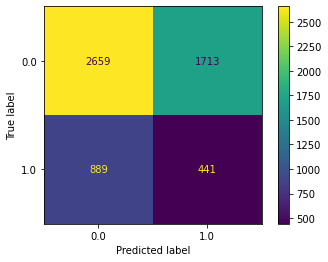

In [77]:
#MAKING A NEW RFC
RFC = RandomForestClassifier(n_estimators=100, n_jobs = -1, criterion = 'entropy', max_depth = 5, random_state = 25)
#RFC.fit(df_stream_xTrain, df_stream_yTrain)
RFC.fit(df_stream_xTrain_smote, df_stream_yTrain_smote)

print("RANDOM FOREST RESULTS: \n")        
y_pred_stream = RFC.predict(df_stream_xTest)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(df_stream_yTest, y_pred_stream),
                               display_labels=RFC.classes_)
disp.plot()
print(classification_report(df_stream_yTest, y_pred_stream))

## LSTM DF1

In [78]:
#LSTM Data transforming
df_stream_xTrain_ri = df_stream_xTrain.reset_index()
df_stream_xTrain_ri = df_stream_xTrain_ri.drop('index', axis = 1)

df_stream_y_LSTM = df_stream_train['TTF_FlowCool Pressure Dropped Below Limit']
df_stream_y_LSTM = df_stream_y_LSTM.reset_index()
df_stream_y_LSTM = df_stream_y_LSTM.drop('index', axis = 1)

df_stream_xTrain_LSTM = df_stream_xTrain_ri.loc[:int(len(df_stream_xTrain_ri) * 0.8)]
df_stream_yTrain_LSTM = df_stream_y_LSTM.loc[:int(len(df_stream_y_LSTM) * 0.8)]

df_stream_xVal_LSTM = df_stream_xTrain_ri.loc[int(len(df_stream_xTrain_ri) * 0.8):]
df_stream_yVal_LSTM = df_stream_y_LSTM.loc[int(len(df_stream_y_LSTM) * 0.8):]

df_stream_xTest_ri = df_stream_xTest.reset_index()
df_stream_xTest_LSTM = df_stream_xTest_ri.drop('index', axis = 1)

df_stream_yTest_LSTM = df_stream_test['TTF_FlowCool Pressure Dropped Below Limit']
df_stream_yTest_LSTM = df_stream_yTest_LSTM.reset_index()
df_stream_yTest_LSTM = df_stream_yTest_LSTM.drop('index', axis = 1)

df_stream_xTrain_LSTM = np.array(df_stream_xTrain_LSTM)
train_X = df_stream_xTrain_LSTM.reshape(df_stream_xTrain_LSTM.shape[0],1,df_stream_xTrain_LSTM.shape[1])
df_stream_yTrain_LSTM = np.array(df_stream_yTrain_LSTM)

df_stream_xVal_LSTM = np.array(df_stream_xVal_LSTM)
val_X = df_stream_xVal_LSTM.reshape(df_stream_xVal_LSTM.shape[0],1,df_stream_xVal_LSTM.shape[1])
df_stream_yVal_LSTM = np.array(df_stream_yVal_LSTM)

df_stream_xTest_LSTM = np.array(df_stream_xTest_LSTM)
test_X = df_stream_xTest_LSTM.reshape(df_stream_xTest_LSTM.shape[0],1,df_stream_xTest_LSTM.shape[1])
df_stream_yTest_LSTM = np.array(df_stream_yTest_LSTM)

In [79]:
model1 = Sequential()
model1.add(LSTM(50, activation ='relu', input_shape=(1,10), return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(50, activation ='relu', return_sequences = False))
model1.add(Dropout(0.2))
model1.add(Dense(1))
model1.compile(optimizer = 'adam', loss ='mse', metrics=['RootMeanSquaredError'])
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 50)             12200     
                                                                 
 dropout_6 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 32,451
Trainable params: 32,451
Non-trainable params: 0
_________________________________________________________________


In [80]:
history1 = model1.fit(train_X, df_stream_yTrain_LSTM, epochs=10, batch_size =16, validation_data =(val_X, df_stream_yVal_LSTM), verbose =1, shuffle=False)

Epoch 1/10
6897/6897 [==============================] - 36s 5ms/step - loss: 71408744.0000 - root_mean_squared_error: 8450.3691 - val_loss: 44224996.0000 - val_root_mean_squared_error: 6650.1875
Epoch 2/10
6897/6897 [==============================] - 31s 4ms/step - loss: 51714604.0000 - root_mean_squared_error: 7191.2866 - val_loss: 42320000.0000 - val_root_mean_squared_error: 6505.3823
Epoch 3/10
6897/6897 [==============================] - 32s 5ms/step - loss: 50614328.0000 - root_mean_squared_error: 7114.3745 - val_loss: 41917968.0000 - val_root_mean_squared_error: 6474.4087
Epoch 4/10
6897/6897 [==============================] - 32s 5ms/step - loss: 50159648.0000 - root_mean_squared_error: 7082.3477 - val_loss: 41827376.0000 - val_root_mean_squared_error: 6467.4087
Epoch 5/10
6897/6897 [==============================] - 35s 5ms/step - loss: 50259112.0000 - root_mean_squared_error: 7089.3662 - val_loss: 41815376.0000 - val_root_mean_squared_error: 6466.4810
Epoch 6/10
6897/6897 [===

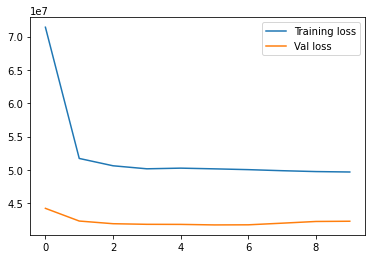

In [81]:
plt.plot(history1.history['loss'], label='Training loss')
plt.plot(history1.history['val_loss'], label='Val loss')
plt.legend()
plt.show()

179/179 [==============================] - 0s 2ms/step - loss: 61567768.0000 - root_mean_squared_error: 7846.5132
score 61567768.00
score 7846.51
179/179 [==============================] - 1s 2ms/step
R2 Score:  -0.1967763437276342
MAE:  6688.0896383156405


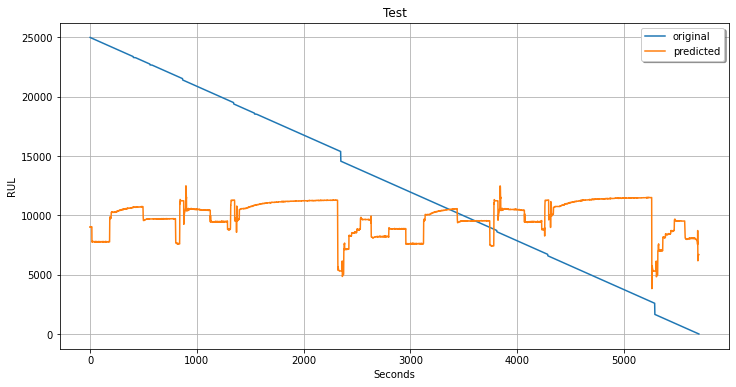

In [82]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

score, acc, = model1.evaluate(test_X, df_stream_yTest_LSTM)
print('score %.2f'%score)
print('score %.2f'%acc)

y_pred = model1.predict(test_X)
print('R2 Score: ', r2_score(df_stream_yTest_LSTM, y_pred))
print('MAE: ', mean_absolute_error(df_stream_yTest_LSTM, y_pred))

x_ax = range(len(df_stream_yTest_LSTM))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, df_stream_yTest_LSTM, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Test")
plt.xlabel('Seconds')
plt.ylabel('RUL')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

863/863 [==============================] - 2s 2ms/step - loss: 42288948.0000 - root_mean_squared_error: 6502.9951
score 42288948.00
score 6503.00
863/863 [==============================] - 2s 2ms/step
R2 Score:  -0.13581620018066198
MAE:  5551.093486265112


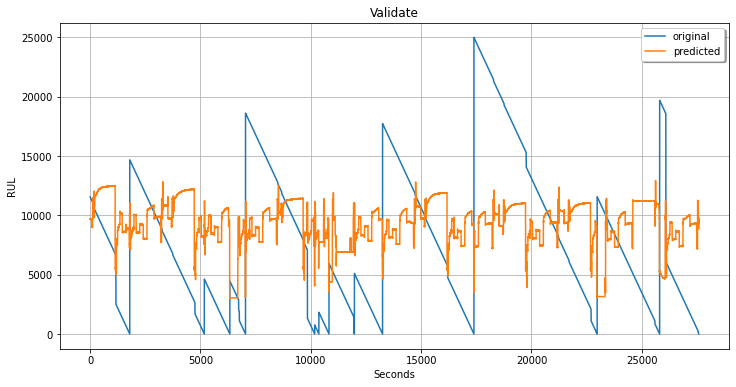

In [83]:
score, acc, = model1.evaluate(val_X, df_stream_yVal_LSTM)
print('score %.2f'%score)
print('score %.2f'%acc)

y_pred_val = model1.predict(val_X)
print('R2 Score: ', r2_score(df_stream_yVal_LSTM, y_pred_val))
print('MAE: ', mean_absolute_error(df_stream_yVal_LSTM, y_pred_val))

x_ax = range(len(df_stream_yVal_LSTM))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, df_stream_yVal_LSTM, label="original")
plt.plot(x_ax, y_pred_val, label="predicted")
plt.title("Validate")
plt.xlabel('Seconds')
plt.ylabel('RUL')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

3449/3449 [==============================] - 7s 2ms/step - loss: 51646640.0000 - root_mean_squared_error: 7186.5596
score 51646640.00
score 7186.56
3449/3449 [==============================] - 6s 2ms/step
R2 Score:  0.03511249189527266
MAE:  5956.320011225308


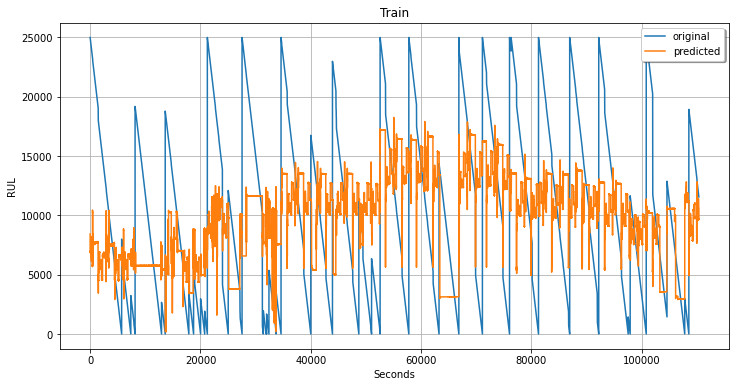

In [84]:
score, acc, = model1.evaluate(train_X, df_stream_yTrain_LSTM)
print('score %.2f'%score)
print('score %.2f'%acc)

y_pred_train = model1.predict(train_X)
print('R2 Score: ', r2_score(df_stream_yTrain_LSTM, y_pred_train))
print('MAE: ', mean_absolute_error(df_stream_yTrain_LSTM, y_pred_train))

x_ax = range(len(df_stream_yTrain_LSTM))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, df_stream_yTrain_LSTM, label="original")
plt.plot(x_ax, y_pred_train, label="predicted")
plt.title("Train")
plt.xlabel('Seconds')
plt.ylabel('RUL')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

## RFR DF1

In [85]:
#next, regression
RFR = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_features='sqrt', oob_score=True)
RFR.fit(df_stream_xTrain, df_stream_train['TTF_FlowCool Pressure Dropped Below Limit'])
y_prediction = RFR.predict(df_stream_xTest)

score=r2_score(df_stream_test['TTF_FlowCool Pressure Dropped Below Limit'],y_prediction)
print('r2 score is:',score)
print('mean absolute error is:',mean_absolute_error(df_stream_yTest,y_prediction))
print('root_mean_squared error of is:',np.sqrt(mean_squared_error(df_stream_yTest,y_prediction)))

r2 score is: -0.19334137516542804
mean absolute error is: 11830.938095092219
root_mean_squared error of is: 12042.31623604852


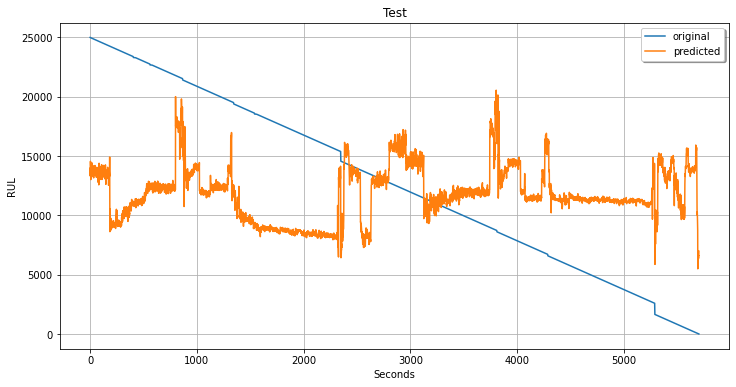

In [86]:
x_ax = range(len(df_stream_test['TTF_FlowCool Pressure Dropped Below Limit']))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, df_stream_test['TTF_FlowCool Pressure Dropped Below Limit'], label="original")
plt.plot(x_ax, y_prediction, label="predicted")
plt.title("Test")
plt.xlabel('Seconds')
plt.ylabel('RUL')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

In [1]:
# j = np.where(y_pred_stream == 1)
# for i in range(len(j[0])):
#     display(df_stream_test['TTF_FlowCool Pressure Dropped Below Limit'].iloc[[j[0][i]]])

## LASSO DF1

In [88]:
from sklearn.linear_model import Lasso

laso = Lasso()
laso.fit(df_stream_xTrain, df_stream_train['TTF_FlowCool Pressure Dropped Below Limit'])
y_prediction = laso.predict(df_stream_xTest)

score=r2_score(df_stream_test['TTF_FlowCool Pressure Dropped Below Limit'],y_prediction)
print('r2 score is:',score)
print('mean absolute error is:',mean_absolute_error(df_stream_yTest,y_prediction))
print('root_mean_squared error of is:',np.sqrt(mean_squared_error(df_stream_yTest,y_prediction)))

r2 score is: -0.21120429128923068
mean absolute error is: 9824.34576899064
root_mean_squared error of is: 9884.856038317193


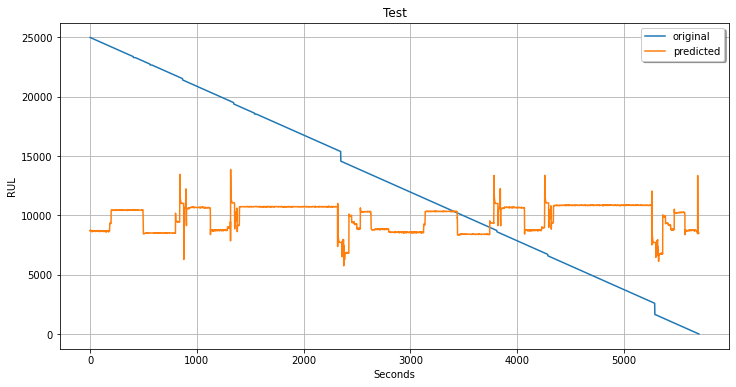

In [89]:
x_ax = range(len(df_stream_test['TTF_FlowCool Pressure Dropped Below Limit']))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, df_stream_test['TTF_FlowCool Pressure Dropped Below Limit'], label="original")
plt.plot(x_ax, y_prediction, label="predicted")
plt.title("Test")
plt.xlabel('Seconds')
plt.ylabel('RUL')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

## RIDGE DF1

In [90]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(df_stream_xTrain, df_stream_train['TTF_FlowCool Pressure Dropped Below Limit'])
y_prediction = ridge.predict(df_stream_xTest)

score=r2_score(df_stream_test['TTF_FlowCool Pressure Dropped Below Limit'],y_prediction)
print('r2 score is:',score)
print('mean absolute error is:',mean_absolute_error(df_stream_yTest,y_prediction))
print('root_mean_squared error of is:',np.sqrt(mean_squared_error(df_stream_yTest,y_prediction)))

r2 score is: -0.2115640432885877
mean absolute error is: 9823.918874740284
root_mean_squared error of is: 9884.7758726978


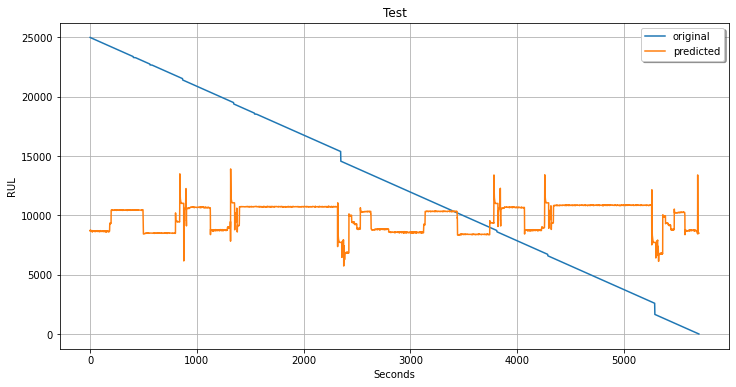

In [91]:
x_ax = range(len(df_stream_test['TTF_FlowCool Pressure Dropped Below Limit']))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, df_stream_test['TTF_FlowCool Pressure Dropped Below Limit'], label="original")
plt.plot(x_ax, y_prediction, label="predicted")
plt.title("Test")
plt.xlabel('Seconds')
plt.ylabel('RUL')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

# Fault 2 (TTF_Flowcool Pressure Too High Check Flowcool Pump)



## RFC DF2

In [92]:
#prod
#get data with 86400 points from 0 as relevant and 20000 point from 0 being fail data
df1, df2, df3 = PreProcess_Data(df_f1, df_f2, df_f3, 25000, 6250)

#drop categorical columns and highly coorelated columns
df_temp = df2[['TTF_Flowcool Pressure Too High Check Flowcool Pump', 'IsFailure']]
df2 = df2.drop(['stage', 'recipe', 'recipe_step',  'Lot', 'runnum', 'ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE', 'ETCHSUPPRESSORCURRENT', 'ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER', 'TTF_Flowcool Pressure Too High Check Flowcool Pump', 'IsFailure'], axis=1)

#implement a standard scaler to normalize the dataset, but not scaling the target values.
scaler = StandardScaler()
scaler.fit(df2)
df2_scaled = scaler.transform(df2)
df2_scaled = pd.DataFrame(df2_scaled, columns = df2.columns)
#reintroduce the target values
df_index = pd.DataFrame(df_temp.index.values)
df2_scaled = pd.concat([df2_scaled, df_index], axis=1, join = 'inner')
df2_scaled = df2_scaled.set_index(0)
df2_scaled = pd.concat([df2_scaled, df_temp ], axis=1, join = 'inner')

#get indices where TTF is 0 from df1
zero_index = df2_scaled.index[df2_scaled['TTF_Flowcool Pressure Too High Check Flowcool Pump'] == 0].tolist()
#get data from the third to last 0, until the second to last 0. This will be the test data
df_stream = df2_scaled.loc[zero_index[-4] : zero_index[-3]]
#zero_index of 9-10, 17-18, 22-23 are the large slices of data

#train data is all data until the third to last 0
df_stream_train = df2_scaled
df_stream_train.drop(df_stream.index, axis = 0, inplace = True)

df_stream_xTrain = df_stream_train.drop(['TTF_Flowcool Pressure Too High Check Flowcool Pump', 'IsFailure'], axis=1)
df_stream_yTrain = df_stream_train['IsFailure']
#Use SMOTE to oversample the minority class
oversample = SMOTE()
df_stream_xTrain_smote, df_stream_yTrain_smote = oversample.fit_resample(df_stream_xTrain, df_stream_yTrain)

#test data is from the last uninterupted count to 0 in the dataset
df_stream_test = df_stream.loc[df_stream[df_stream['TTF_Flowcool Pressure Too High Check Flowcool Pump'] > df_stream['TTF_Flowcool Pressure Too High Check Flowcool Pump'].shift().rolling(2, min_periods=1).min()].tail(1).index.item():]

df_stream_xTest = df_stream_test.drop(['TTF_Flowcool Pressure Too High Check Flowcool Pump', 'IsFailure'], axis=1)
df_stream_yTest = df_stream_test['IsFailure']

RANDOM FOREST RESULTS: 

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     917.0
         1.0       0.00      0.00      0.00    1448.0

    accuracy                           0.00    2365.0
   macro avg       0.00      0.00      0.00    2365.0
weighted avg       0.00      0.00      0.00    2365.0



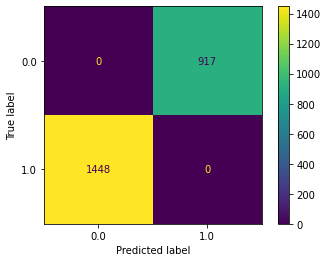

In [93]:
#MAKING A NEW RFC
RFC = RandomForestClassifier(n_estimators=100, n_jobs = -1, criterion = 'entropy', max_depth = 5, random_state = 25)
#RFC.fit(df_stream_xTrain, df_stream_yTrain)
RFC.fit(df_stream_xTrain_smote, df_stream_yTrain_smote)

print("RANDOM FOREST RESULTS: \n")        
y_pred_stream = RFC.predict(df_stream_xTest)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(df_stream_yTest, y_pred_stream),
                               display_labels=RFC.classes_)
disp.plot()
print(classification_report(df_stream_yTest, y_pred_stream))

## LSTM DF2

In [94]:
#LSTM Data transforming
df_stream_xTrain_ri = df_stream_xTrain.reset_index()
df_stream_xTrain_ri = df_stream_xTrain_ri.drop('index', axis = 1)

df_stream_y_LSTM = df_stream_train['TTF_Flowcool Pressure Too High Check Flowcool Pump']
df_stream_y_LSTM = df_stream_y_LSTM.reset_index()
df_stream_y_LSTM = df_stream_y_LSTM.drop('index', axis = 1)

df_stream_xTrain_LSTM = df_stream_xTrain_ri.loc[:int(len(df_stream_xTrain_ri) * 0.8)]
df_stream_yTrain_LSTM = df_stream_y_LSTM.loc[:int(len(df_stream_y_LSTM) * 0.8)]

df_stream_xVal_LSTM = df_stream_xTrain_ri.loc[int(len(df_stream_xTrain_ri) * 0.8):]
df_stream_yVal_LSTM = df_stream_y_LSTM.loc[int(len(df_stream_y_LSTM) * 0.8):]

df_stream_xTest_ri = df_stream_xTest.reset_index()
df_stream_xTest_LSTM = df_stream_xTest_ri.drop('index', axis = 1)

df_stream_yTest_LSTM = df_stream_test['TTF_Flowcool Pressure Too High Check Flowcool Pump']
df_stream_yTest_LSTM = df_stream_yTest_LSTM.reset_index()
df_stream_yTest_LSTM = df_stream_yTest_LSTM.drop('index', axis = 1)

df_stream_xTrain_LSTM = np.array(df_stream_xTrain_LSTM)
train_X = df_stream_xTrain_LSTM.reshape(df_stream_xTrain_LSTM.shape[0],1,df_stream_xTrain_LSTM.shape[1])
df_stream_yTrain_LSTM = np.array(df_stream_yTrain_LSTM)

df_stream_xVal_LSTM = np.array(df_stream_xVal_LSTM)
val_X = df_stream_xVal_LSTM.reshape(df_stream_xVal_LSTM.shape[0],1,df_stream_xVal_LSTM.shape[1])
df_stream_yVal_LSTM = np.array(df_stream_yVal_LSTM)

df_stream_xTest_LSTM = np.array(df_stream_xTest_LSTM)
test_X = df_stream_xTest_LSTM.reshape(df_stream_xTest_LSTM.shape[0],1,df_stream_xTest_LSTM.shape[1])
df_stream_yTest_LSTM = np.array(df_stream_yTest_LSTM)

In [95]:
model1 = Sequential()
model1.add(LSTM(50, activation ='relu', input_shape=(1,10), return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(50, activation ='relu', return_sequences = False))
model1.add(Dropout(0.2))
model1.add(Dense(1))
model1.compile(optimizer = 'adam', loss ='mse', metrics=['RootMeanSquaredError'])
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1, 50)             12200     
                                                                 
 dropout_8 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_9 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 32,451
Trainable params: 32,451
Non-trainable params: 0
_________________________________________________________________


In [96]:
history1 = model1.fit(train_X, df_stream_yTrain_LSTM, epochs=10, batch_size =16, validation_data =(val_X, df_stream_yVal_LSTM), verbose =1, shuffle=False)

Epoch 1/10
254/254 [==============================] - 8s 10ms/step - loss: 71470912.0000 - root_mean_squared_error: 8454.0469 - val_loss: 719776.3125 - val_root_mean_squared_error: 848.3963
Epoch 2/10
254/254 [==============================] - 2s 8ms/step - loss: 65104772.0000 - root_mean_squared_error: 8068.7529 - val_loss: 293782.0938 - val_root_mean_squared_error: 542.0167
Epoch 3/10
254/254 [==============================] - 2s 8ms/step - loss: 40876644.0000 - root_mean_squared_error: 6393.4844 - val_loss: 3692372.2500 - val_root_mean_squared_error: 1921.5547
Epoch 4/10
254/254 [==============================] - 2s 7ms/step - loss: 19937432.0000 - root_mean_squared_error: 4465.1353 - val_loss: 9060803.0000 - val_root_mean_squared_error: 3010.1167
Epoch 5/10
254/254 [==============================] - 2s 7ms/step - loss: 13498160.0000 - root_mean_squared_error: 3673.9841 - val_loss: 11402658.0000 - val_root_mean_squared_error: 3376.7822
Epoch 6/10
254/254 [===========================

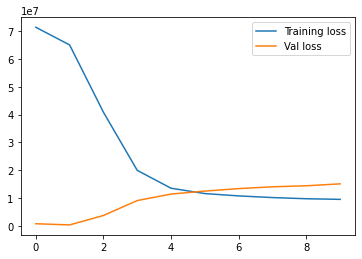

In [97]:
plt.plot(history1.history['loss'], label='Training loss')
plt.plot(history1.history['val_loss'], label='Val loss')
plt.legend()
plt.show()

74/74 [==============================] - 0s 3ms/step - loss: 49574400.0000 - root_mean_squared_error: 7040.9092
score 49574400.00
score 7040.91
74/74 [==============================] - 0s 2ms/step
R2 Score:  -2.889427956276027
MAE:  6551.873139634244


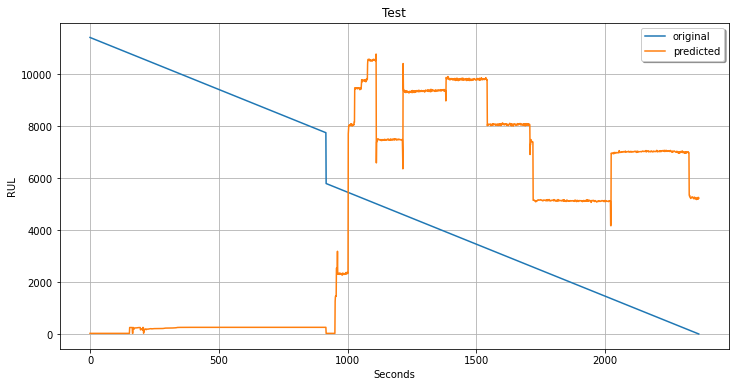

In [98]:
score, acc, = model1.evaluate(test_X, df_stream_yTest_LSTM)
print('score %.2f'%score)
print('score %.2f'%acc)

y_pred = model1.predict(test_X)
print('R2 Score: ', r2_score(df_stream_yTest_LSTM, y_pred))
print('MAE: ', mean_absolute_error(df_stream_yTest_LSTM, y_pred))

x_ax = range(len(df_stream_yTest_LSTM))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, df_stream_yTest_LSTM, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Test")
plt.xlabel('Seconds')
plt.ylabel('RUL')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

32/32 [==============================] - 0s 3ms/step - loss: 15082671.0000 - root_mean_squared_error: 3883.6414
score 15082671.00
score 3883.64
32/32 [==============================] - 0s 3ms/step
R2 Score:  -61.89305379438302
MAE:  3206.236193584574


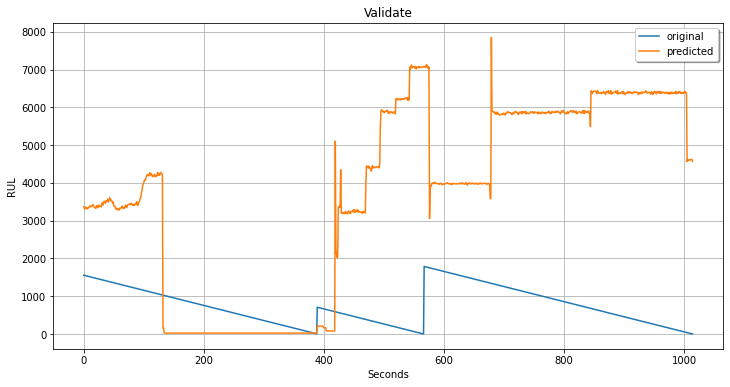

In [99]:
score, acc, = model1.evaluate(val_X, df_stream_yVal_LSTM)
print('score %.2f'%score)
print('score %.2f'%acc)

y_pred_val = model1.predict(val_X)
print('R2 Score: ', r2_score(df_stream_yVal_LSTM, y_pred_val))
print('MAE: ', mean_absolute_error(df_stream_yVal_LSTM, y_pred_val))

x_ax = range(len(df_stream_yVal_LSTM))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, df_stream_yVal_LSTM, label="original")
plt.plot(x_ax, y_pred_val, label="predicted")
plt.title("Validate")
plt.xlabel('Seconds')
plt.ylabel('RUL')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

127/127 [==============================] - 0s 2ms/step - loss: 8283038.5000 - root_mean_squared_error: 2878.0269
score 8283038.50
score 2878.03
127/127 [==============================] - 0s 2ms/step
R2 Score:  0.4747122347152276
MAE:  2007.3098353150738


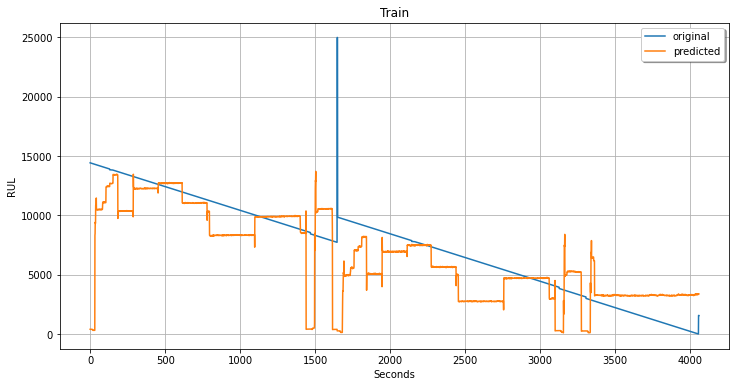

In [100]:
score, acc, = model1.evaluate(train_X, df_stream_yTrain_LSTM)
print('score %.2f'%score)
print('score %.2f'%acc)

y_pred_train = model1.predict(train_X)
print('R2 Score: ', r2_score(df_stream_yTrain_LSTM, y_pred_train))
print('MAE: ', mean_absolute_error(df_stream_yTrain_LSTM, y_pred_train))

x_ax = range(len(df_stream_yTrain_LSTM))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, df_stream_yTrain_LSTM, label="original")
plt.plot(x_ax, y_pred_train, label="predicted")
plt.title("Train")
plt.xlabel('Seconds')
plt.ylabel('RUL')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

## RFR DF2

In [101]:
#next, regression
RFR = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_features='sqrt', oob_score=True)
RFR.fit(df_stream_xTrain, df_stream_train['TTF_Flowcool Pressure Too High Check Flowcool Pump'])
y_prediction = RFR.predict(df_stream_xTest)

score=r2_score(df_stream_test['TTF_Flowcool Pressure Too High Check Flowcool Pump'],y_prediction)
print('r2 score is:',score)
print('mean absolute error is:',mean_absolute_error(df_stream_yTest,y_prediction))
print('root_mean_squared error of is:',np.sqrt(mean_squared_error(df_stream_yTest,y_prediction)))

r2 score is: -2.91703505284238
mean absolute error is: 7039.176298761702
root_mean_squared error of is: 7867.766642001016


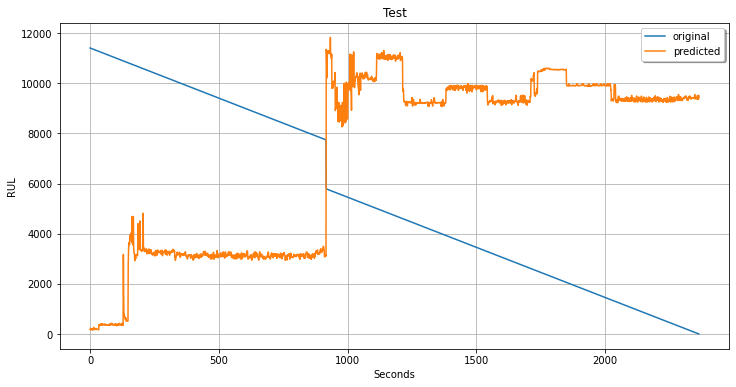

In [102]:
x_ax = range(len(df_stream_test['TTF_Flowcool Pressure Too High Check Flowcool Pump']))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, df_stream_test['TTF_Flowcool Pressure Too High Check Flowcool Pump'], label="original")
plt.plot(x_ax, y_prediction, label="predicted")
plt.title("Test")
plt.xlabel('Seconds')
plt.ylabel('RUL')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

In [2]:
# j = np.where(y_pred_stream == 1)
# for i in range(len(j[0])):
#     display(df_stream_test['TTF_Flowcool Pressure Too High Check Flowcool Pump'].iloc[[j[0][i]]])

## LASSO DF2

In [104]:
from sklearn.linear_model import Lasso

laso = Lasso()
laso.fit(df_stream_xTrain, df_stream_train['TTF_Flowcool Pressure Too High Check Flowcool Pump'])
y_prediction = laso.predict(df_stream_xTest)

score=r2_score(df_stream_test['TTF_Flowcool Pressure Too High Check Flowcool Pump'],y_prediction)
print('r2 score is:',score)
print('mean absolute error is:',mean_absolute_error(df_stream_yTest,y_prediction))
print('root_mean_squared error of is:',np.sqrt(mean_squared_error(df_stream_yTest,y_prediction)))

r2 score is: -849.5303185014782
mean absolute error is: 9067.810393081661
root_mean_squared error of is: 103707.66221394838


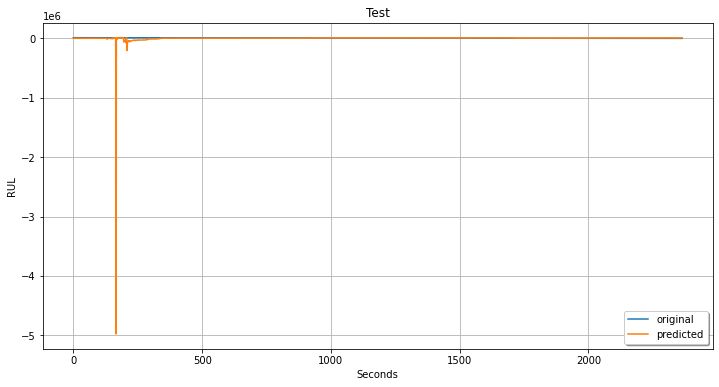

In [105]:
x_ax = range(len(df_stream_test['TTF_Flowcool Pressure Too High Check Flowcool Pump']))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, df_stream_test['TTF_Flowcool Pressure Too High Check Flowcool Pump'], label="original")
plt.plot(x_ax, y_prediction, label="predicted")
plt.title("Test")
plt.xlabel('Seconds')
plt.ylabel('RUL')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

## RIDGE DF2

In [106]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(df_stream_xTrain, df_stream_train['TTF_Flowcool Pressure Too High Check Flowcool Pump'])
y_prediction = ridge.predict(df_stream_xTest)

score=r2_score(df_stream_test['TTF_Flowcool Pressure Too High Check Flowcool Pump'],y_prediction)
print('r2 score is:',score)
print('mean absolute error is:',mean_absolute_error(df_stream_yTest,y_prediction))
print('root_mean_squared error of is:',np.sqrt(mean_squared_error(df_stream_yTest,y_prediction)))

r2 score is: -114.27514065376819
mean absolute error is: 6442.86950547272
root_mean_squared error of is: 38011.626977287706


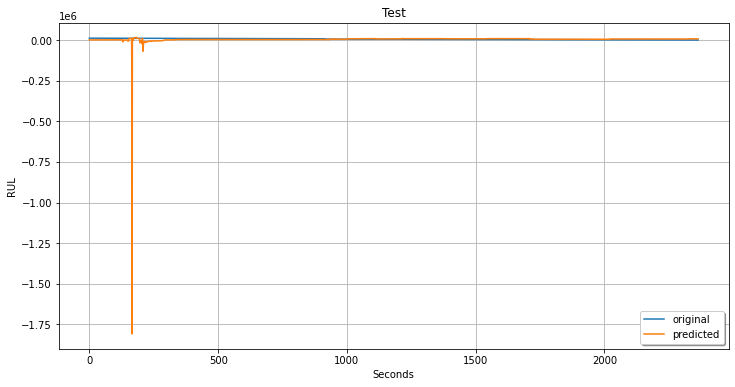

In [107]:
x_ax = range(len(df_stream_test['TTF_Flowcool Pressure Too High Check Flowcool Pump']))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, df_stream_test['TTF_Flowcool Pressure Too High Check Flowcool Pump'], label="original")
plt.plot(x_ax, y_prediction, label="predicted")
plt.title("Test")
plt.xlabel('Seconds')
plt.ylabel('RUL')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

# Fault 3 (TTF_Flowcool leak)

## RFC DF3

In [160]:
#prod
#get data with 86400 points from 0 as relevant and 20000 point from 0 being fail data
df1, df2, df3 = PreProcess_Data(df_f1, df_f2, df_f3, 10000, 2500)

#drop categorical columns and highly coorelated columns
df_temp = df3[['TTF_Flowcool leak', 'IsFailure']]
df3 = df3.drop(['stage', 'recipe', 'recipe_step',  'Lot', 'runnum', 'ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE', 'ETCHSUPPRESSORCURRENT', 'ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER', 'TTF_Flowcool leak', 'IsFailure'], axis=1)

#implement a standard scaler to normalize the dataset, but not scaling the target values.
scaler = StandardScaler()
scaler.fit(df3)
df3_scaled = scaler.transform(df3)
df3_scaled = pd.DataFrame(df3_scaled, columns = df3.columns)
#reintroduce the target values
df_index = pd.DataFrame(df_temp.index.values)
df3_scaled = pd.concat([df3_scaled, df_index], axis=1, join = 'inner')
df3_scaled = df3_scaled.set_index(0)
df3_scaled = pd.concat([df3_scaled, df_temp ], axis=1, join = 'inner')

#get indices where TTF is 0 from df1
zero_index = df3_scaled.index[df3_scaled['TTF_Flowcool leak'] == 0].tolist()
#get data from the third to last 0, until the second to last 0. This will be the test data
df_stream = df3_scaled.loc[zero_index[-7] : zero_index[-6]]
#zero_index of 9-10, 17-18, 22-23 are the large slices of data

#train data is all data until the third to last 0
df_stream_train = df3_scaled
df_stream_train.drop(df_stream.index, axis = 0, inplace = True)

df_stream_xTrain = df_stream_train.drop(['TTF_Flowcool leak', 'IsFailure'], axis=1)
df_stream_yTrain = df_stream_train['IsFailure']
#Use SMOTE to oversample the minority class
oversample = SMOTE()
df_stream_xTrain_smote, df_stream_yTrain_smote = oversample.fit_resample(df_stream_xTrain, df_stream_yTrain)

#test data is from the last uninterupted count to 0 in the dataset
df_stream_test = df_stream.loc[df_stream[df_stream['TTF_Flowcool leak'] > df_stream['TTF_Flowcool leak'].shift().rolling(2, min_periods=1).min()].tail(1).index.item():]

df_stream_xTest = df_stream_test.drop(['TTF_Flowcool leak', 'IsFailure'], axis=1)
df_stream_yTest = df_stream_test['IsFailure']

RANDOM FOREST RESULTS: 

              precision    recall  f1-score   support

         0.0       0.11      1.00      0.20        64
         1.0       1.00      0.67      0.80      1563

    accuracy                           0.69      1627
   macro avg       0.56      0.84      0.50      1627
weighted avg       0.97      0.69      0.78      1627



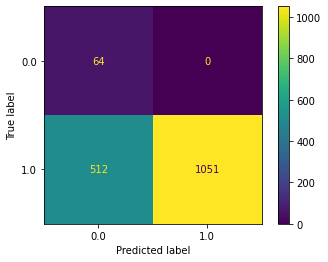

In [109]:
#MAKING A NEW RFC
RFC = RandomForestClassifier(n_estimators=100, n_jobs = -1, criterion = 'entropy', max_depth = 5, random_state = 25)
#RFC.fit(df_stream_xTrain, df_stream_yTrain)
RFC.fit(df_stream_xTrain_smote, df_stream_yTrain_smote)

print("RANDOM FOREST RESULTS: \n")        
y_pred_stream = RFC.predict(df_stream_xTest)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(df_stream_yTest, y_pred_stream),
                               display_labels=RFC.classes_)
disp.plot()
print(classification_report(df_stream_yTest, y_pred_stream))

## LSTM DF3

In [161]:
#LSTM Data transforming
df_stream_xTrain_ri = df_stream_xTrain.reset_index()
df_stream_xTrain_ri = df_stream_xTrain_ri.drop('index', axis = 1)

df_stream_y_LSTM = df_stream_train['TTF_Flowcool leak']
df_stream_y_LSTM = df_stream_y_LSTM.reset_index()
df_stream_y_LSTM = df_stream_y_LSTM.drop('index', axis = 1)

df_stream_xTrain_LSTM = df_stream_xTrain_ri.loc[:int(len(df_stream_xTrain_ri) * 0.8)]
df_stream_yTrain_LSTM = df_stream_y_LSTM.loc[:int(len(df_stream_y_LSTM) * 0.8)]

df_stream_xVal_LSTM = df_stream_xTrain_ri.loc[int(len(df_stream_xTrain_ri) * 0.8):]
df_stream_yVal_LSTM = df_stream_y_LSTM.loc[int(len(df_stream_y_LSTM) * 0.8):]

df_stream_xTest_ri = df_stream_xTest.reset_index()
df_stream_xTest_LSTM = df_stream_xTest_ri.drop('index', axis = 1)

df_stream_yTest_LSTM = df_stream_test['TTF_Flowcool leak']
df_stream_yTest_LSTM = df_stream_yTest_LSTM.reset_index()
df_stream_yTest_LSTM = df_stream_yTest_LSTM.drop('index', axis = 1)

df_stream_xTrain_LSTM = np.array(df_stream_xTrain_LSTM)
train_X = df_stream_xTrain_LSTM.reshape(df_stream_xTrain_LSTM.shape[0],1,df_stream_xTrain_LSTM.shape[1])
df_stream_yTrain_LSTM = np.array(df_stream_yTrain_LSTM)

df_stream_xVal_LSTM = np.array(df_stream_xVal_LSTM)
val_X = df_stream_xVal_LSTM.reshape(df_stream_xVal_LSTM.shape[0],1,df_stream_xVal_LSTM.shape[1])
df_stream_yVal_LSTM = np.array(df_stream_yVal_LSTM)

df_stream_xTest_LSTM = np.array(df_stream_xTest_LSTM)
test_X = df_stream_xTest_LSTM.reshape(df_stream_xTest_LSTM.shape[0],1,df_stream_xTest_LSTM.shape[1])
df_stream_yTest_LSTM = np.array(df_stream_yTest_LSTM)

In [162]:
model1 = Sequential()
model1.add(LSTM(50, activation ='relu', input_shape=(1,10), return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(50, activation ='relu', return_sequences = False))
model1.add(Dropout(0.2))
model1.add(Dense(1))
model1.compile(optimizer = 'adam', loss ='mse', metrics=['RootMeanSquaredError'])
model1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 1, 50)             12200     
                                                                 
 dropout_16 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_17 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_17 (Dropout)        (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 32,451
Trainable params: 32,451
Non-trainable params: 0
_________________________________________________________________


In [163]:
history1 = model1.fit(train_X, df_stream_yTrain_LSTM, epochs=10, batch_size =16, validation_data =(val_X, df_stream_yVal_LSTM), verbose =1, shuffle=False)

Epoch 1/10
1219/1219 [==============================] - 9s 4ms/step - loss: 14897016.0000 - root_mean_squared_error: 3859.6653 - val_loss: 6372222.5000 - val_root_mean_squared_error: 2524.3262
Epoch 2/10
1219/1219 [==============================] - 6s 5ms/step - loss: 7235297.5000 - root_mean_squared_error: 2689.8508 - val_loss: 6472498.0000 - val_root_mean_squared_error: 2544.1104
Epoch 3/10
1219/1219 [==============================] - 5s 4ms/step - loss: 7115316.5000 - root_mean_squared_error: 2667.4551 - val_loss: 6530344.0000 - val_root_mean_squared_error: 2555.4539
Epoch 4/10
1219/1219 [==============================] - 5s 4ms/step - loss: 7034966.0000 - root_mean_squared_error: 2652.3511 - val_loss: 6608301.5000 - val_root_mean_squared_error: 2570.6616
Epoch 5/10
1219/1219 [==============================] - 5s 4ms/step - loss: 6954931.5000 - root_mean_squared_error: 2637.2205 - val_loss: 6679238.0000 - val_root_mean_squared_error: 2584.4221
Epoch 6/10
1219/1219 [=================

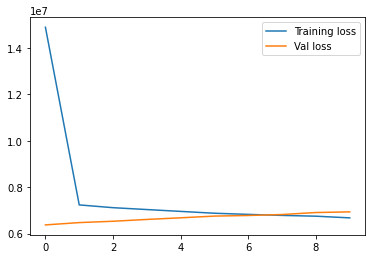

In [164]:
plt.plot(history1.history['loss'], label='Training loss')
plt.plot(history1.history['val_loss'], label='Val loss')
plt.legend()
plt.show()

46/46 [==============================] - 0s 3ms/step - loss: 9960657.0000 - root_mean_squared_error: 3156.0508
score 9960657.00
score 3156.05
46/46 [==============================] - 0s 2ms/step
R2 Score:  -0.18020054410407838
MAE:  2785.023098415799


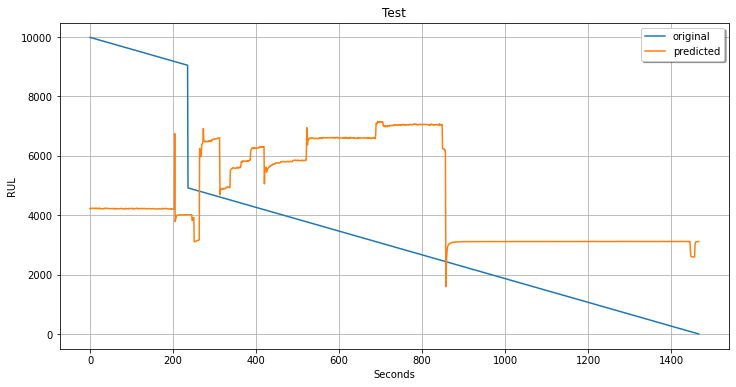

In [165]:
score, acc, = model1.evaluate(test_X, df_stream_yTest_LSTM)
print('score %.2f'%score)
print('score %.2f'%acc)

y_pred = model1.predict(test_X)
print('R2 Score: ', r2_score(df_stream_yTest_LSTM, y_pred))
print('MAE: ', mean_absolute_error(df_stream_yTest_LSTM, y_pred))

x_ax = range(len(df_stream_yTest_LSTM))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, df_stream_yTest_LSTM, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Test")
plt.xlabel('Seconds')
plt.ylabel('RUL')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

299/299 [==============================] - 1s 2ms/step - loss: 45182268.0000 - root_mean_squared_error: 6721.7759
score 45182268.00
score 6721.78
299/299 [==============================] - 1s 2ms/step
R2 Score:  0.11022659584314942
MAE:  5670.69428265791


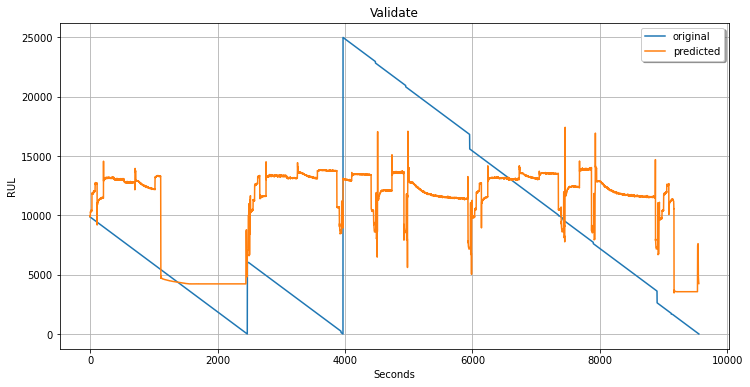

In [115]:
score, acc, = model1.evaluate(val_X, df_stream_yVal_LSTM)
print('score %.2f'%score)
print('score %.2f'%acc)

y_pred_val = model1.predict(val_X)
print('R2 Score: ', r2_score(df_stream_yVal_LSTM, y_pred_val))
print('MAE: ', mean_absolute_error(df_stream_yVal_LSTM, y_pred_val))

x_ax = range(len(df_stream_yVal_LSTM))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, df_stream_yVal_LSTM, label="original")
plt.plot(x_ax, y_pred_val, label="predicted")
plt.title("Validate")
plt.xlabel('Seconds')
plt.ylabel('RUL')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

1195/1195 [==============================] - 3s 2ms/step - loss: 39042380.0000 - root_mean_squared_error: 6248.3901
score 39042380.00
score 6248.39
1195/1195 [==============================] - 2s 2ms/step
R2 Score:  0.2297559872016781
MAE:  5114.329756483151


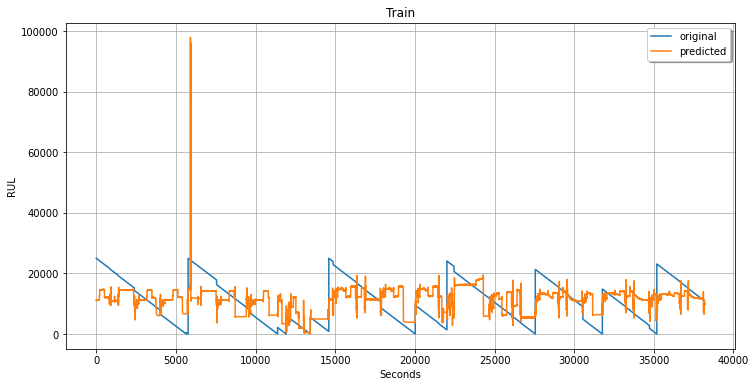

In [116]:
score, acc, = model1.evaluate(train_X, df_stream_yTrain_LSTM)
print('score %.2f'%score)
print('score %.2f'%acc)

y_pred_train = model1.predict(train_X)
print('R2 Score: ', r2_score(df_stream_yTrain_LSTM, y_pred_train))
print('MAE: ', mean_absolute_error(df_stream_yTrain_LSTM, y_pred_train))

x_ax = range(len(df_stream_yTrain_LSTM))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, df_stream_yTrain_LSTM, label="original")
plt.plot(x_ax, y_pred_train, label="predicted")
plt.title("Train")
plt.xlabel('Seconds')
plt.ylabel('RUL')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

## RFR DF3

In [153]:
#next, regression
RFR = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_features='sqrt', oob_score=True)
RFR.fit(df_stream_xTrain, df_stream_train['TTF_Flowcool leak'])
y_prediction = RFR.predict(df_stream_xTest)

score=r2_score(df_stream_test['TTF_Flowcool leak'],y_prediction)
print('r2 score is:',score)
print('mean absolute error is:',mean_absolute_error(df_stream_yTest,y_prediction))
print('root_mean_squared error of is:',np.sqrt(mean_squared_error(df_stream_yTest,y_prediction)))

r2 score is: -0.036996464080013114
mean absolute error is: 8596.184057029748
root_mean_squared error of is: 9006.464591767217


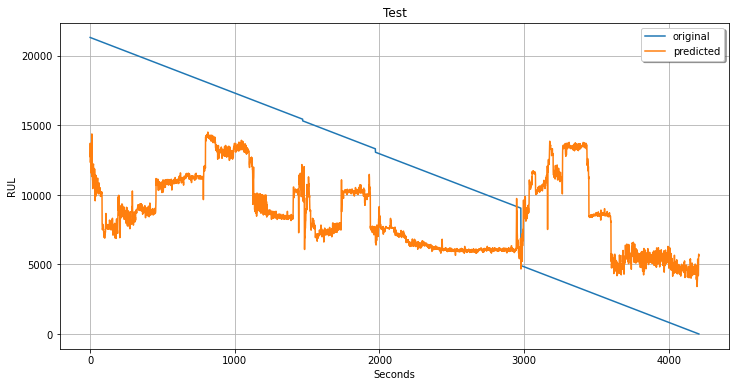

In [154]:
x_ax = range(len(df_stream_test['TTF_Flowcool leak']))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, df_stream_test['TTF_Flowcool leak'], label="original")
plt.plot(x_ax, y_prediction, label="predicted")
plt.title("Test")
plt.xlabel('Seconds')
plt.ylabel('RUL')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

In [3]:
# j = np.where(y_pred_stream == 1)
# for i in range(len(j[0])):
#     display(df_stream_test['TTF_Flowcool leak'].iloc[[j[0][i]]])

## LASSO DF3

In [156]:
from sklearn.linear_model import Lasso

laso = Lasso()
laso.fit(df_stream_xTrain, df_stream_train['TTF_Flowcool leak'])
y_prediction = laso.predict(df_stream_xTest)

score=r2_score(df_stream_test['TTF_Flowcool leak'],y_prediction)
print('r2 score is:',score)
print('mean absolute error is:',mean_absolute_error(df_stream_yTest,y_prediction))
print('root_mean_squared error of is:',np.sqrt(mean_squared_error(df_stream_yTest,y_prediction)))

r2 score is: 0.1450218223869092
mean absolute error is: 10040.797213903927
root_mean_squared error of is: 10233.340922691625


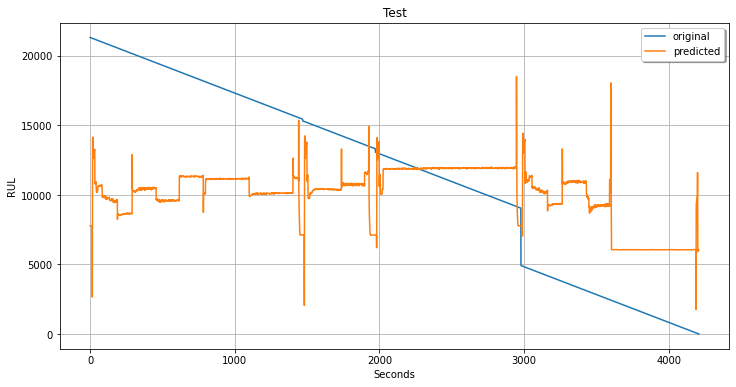

In [157]:
x_ax = range(len(df_stream_test['TTF_Flowcool leak']))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, df_stream_test['TTF_Flowcool leak'], label="original")
plt.plot(x_ax, y_prediction, label="predicted")
plt.title("Test")
plt.xlabel('Seconds')
plt.ylabel('RUL')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

## RIDGE DF3

In [158]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(df_stream_xTrain, df_stream_train['TTF_Flowcool leak'])
y_prediction = ridge.predict(df_stream_xTest)

score=r2_score(df_stream_test['TTF_Flowcool leak'],y_prediction)
print('r2 score is:',score)
print('mean absolute error is:',mean_absolute_error(df_stream_yTest,y_prediction))
print('root_mean_squared error of is:',np.sqrt(mean_squared_error(df_stream_yTest,y_prediction)))

r2 score is: 0.14467865359665766
mean absolute error is: 10040.690095130101
root_mean_squared error of is: 10233.367719818869


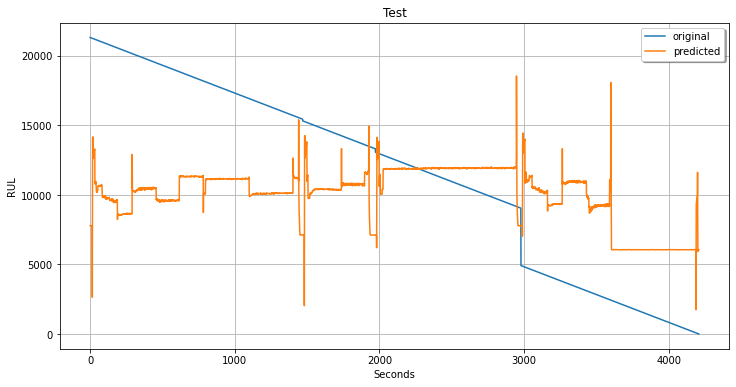

In [159]:
x_ax = range(len(df_stream_test['TTF_Flowcool leak']))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, df_stream_test['TTF_Flowcool leak'], label="original")
plt.plot(x_ax, y_prediction, label="predicted")
plt.title("Test")
plt.xlabel('Seconds')
plt.ylabel('RUL')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  